In [2]:
# ==============================================================================
# Cell 1: Imports, Settings
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype, is_object_dtype

In [3]:
# ==============================================================================
# Cell 2: Load Data
# ==============================================================================
base_path = r"C:\Users\HP\Desktop\Comprehensive_practical\100k_synthea_covid19_csv\files"

file_names = {
    'conditions_df': "conditions.csv",
    'patients_df': "patients.csv",
    'observations_df': "observations.csv",
    'careplans_df': "careplans.csv",
    'encounters_df': "encounters.csv",
    'devices_df': "devices.csv",
    'supplies_df': "supplies.csv",
    'procedures_df': "procedures.csv",
    'medications_df': "medications.csv"
}

dfs = {}
for name, fname in file_names.items():
    path = f"{base_path}\\{fname}"
    try:
        dfs[name] = pd.read_csv(path)
        print(f"Loaded {name} from {fname} — shape: {dfs[name].shape}")
    except FileNotFoundError:
        print(f"⚠️ File not found: {path}. Skipping {name}.")
        dfs[name] = pd.DataFrame()   # keep key consistent

Loaded conditions_df from conditions.csv — shape: (1143900, 6)
Loaded patients_df from patients.csv — shape: (124150, 25)
Loaded observations_df from observations.csv — shape: (16219969, 8)
Loaded careplans_df from careplans.csv — shape: (377726, 9)
Loaded encounters_df from encounters.csv — shape: (3188675, 15)
Loaded devices_df from devices.csv — shape: (23694, 7)
Loaded supplies_df from supplies.csv — shape: (1389858, 6)
Loaded procedures_df from procedures.csv — shape: (979564, 8)
Loaded medications_df from medications.csv — shape: (4227723, 13)


In [4]:
for name, df in dfs.items():
    print(f"\n===== {name} =====")
    if not df.empty:
        print(df.head())
    else:
        print("⚠️ Empty DataFrame (file missing or not loaded).")



===== conditions_df =====
        START        STOP                               PATIENT  \
0  2019-02-15  2019-08-01  1ff7f10f-a204-4bb1-aa72-dd763fa99482   
1  2019-10-30  2020-01-30  1ff7f10f-a204-4bb1-aa72-dd763fa99482   
2  2020-03-01  2020-03-30  1ff7f10f-a204-4bb1-aa72-dd763fa99482   
3  2020-03-01  2020-03-01  1ff7f10f-a204-4bb1-aa72-dd763fa99482   
4  2020-03-01  2020-03-30  1ff7f10f-a204-4bb1-aa72-dd763fa99482   

                              ENCOUNTER       CODE         DESCRIPTION  
0  d317dacb-d801-4136-be7d-440094f7ae83   65363002        Otitis media  
1  759cfd9c-b40b-45df-a5b2-fca418027a6a   65363002        Otitis media  
2  60584c6a-e26b-4176-a660-86ad84c7ceca  386661006     Fever (finding)  
3  60584c6a-e26b-4176-a660-86ad84c7ceca  840544004  Suspected COVID-19  
4  60584c6a-e26b-4176-a660-86ad84c7ceca  840539006            COVID-19  

===== patients_df =====
                                     Id   BIRTHDATE DEATHDATE          SSN  \
0  1ff7f10f-a204-4bb1-aa72-dd

### Cell 3: Filter for COVID-19 Patients
This cell filters the dataset to include only patients who have been diagnosed with COVID-19. It uses the SNOMED code for COVID-19 (840539006) to identify these patients in the `conditions_df` dataframe. Then, it filters all other dataframes to ensure that the subsequent analysis is performed only on this patient cohort.

In [5]:
# ==============================================================================
# Cell 3: Filter for COVID-19 Patients
# ==============================================================================
# SNOMED code for COVID-19 is 840539006
covid_condition_code = 840539006

if 'conditions_df' in dfs and not dfs['conditions_df'].empty:
    conditions_df = dfs['conditions_df']
    covid_patients_ids = conditions_df[conditions_df['CODE'] == covid_condition_code]['PATIENT'].unique()

    # Filter all dataframes to only include COVID-19 patients
    for name, df in dfs.items():
        if 'PATIENT' in df.columns:
            print(f"Filtering {name} for COVID-19 patients...")
            dfs[name] = df[df['PATIENT'].isin(covid_patients_ids)]
            print(f"Shape of {name} after filtering: {dfs[name].shape}")

Filtering conditions_df for COVID-19 patients...
Shape of conditions_df after filtering: (936075, 6)
Filtering observations_df for COVID-19 patients...
Shape of observations_df after filtering: (14384136, 8)
Filtering careplans_df for COVID-19 patients...
Shape of careplans_df after filtering: (291246, 9)
Filtering encounters_df for COVID-19 patients...
Shape of encounters_df after filtering: (1975394, 15)
Filtering devices_df for COVID-19 patients...
Shape of devices_df after filtering: (18557, 7)
Filtering supplies_df for COVID-19 patients...
Shape of supplies_df after filtering: (1389786, 6)
Filtering procedures_df for COVID-19 patients...
Shape of procedures_df after filtering: (795804, 8)
Filtering medications_df for COVID-19 patients...
Shape of medications_df after filtering: (2501594, 13)


In [6]:
# ==============================================================================
# Cell 4: Duplicate Summary Table (BEFORE cleaning)
# ==============================================================================
duplicate_summary = []

for name, df in dfs.items():
    if df.empty:
        continue

    duplicate_rows = df.duplicated().sum()
    duplicate_pct = round((duplicate_rows / len(df)) * 100, 2)

    duplicate_summary.append({
        "Dataset": name,
        "Duplicate Count": duplicate_rows,
        "Duplicate %": duplicate_pct
    })

duplicate_summary_df = pd.DataFrame(duplicate_summary)
print("\nDuplicate Summary Table (BEFORE cleaning):")
print(duplicate_summary_df)


Duplicate Summary Table (BEFORE cleaning):
           Dataset  Duplicate Count  Duplicate %
0    conditions_df                0         0.00
1      patients_df                0         0.00
2  observations_df             5708         0.04
3     careplans_df                0         0.00
4    encounters_df                0         0.00
5       devices_df                0         0.00
6      supplies_df                0         0.00
7    procedures_df                0         0.00
8   medications_df               15         0.00


In [7]:
# ==============================================================================
# Cell 5: Remove duplicate rows (report BEFORE/AFTER)
# ==============================================================================
total_duplicates_per_file = {}

for name, df in list(dfs.items()):
    if df.empty:
        continue

    before = len(df)
    dup_rows = df.duplicated().sum()
    total_duplicates_per_file[name] = dup_rows

    print(f"\n{name}: before={before}, duplicates={dup_rows}")

    # Remove duplicates, keep first occurrence, reset index
    dfs[name] = df.drop_duplicates(keep='first').reset_index(drop=True)

    after = len(dfs[name])
    removed = before - after
    print(f"{name}: after={after}, removed={removed}")

print("\nSummary of duplicates found per file before removal:")
for name, count in total_duplicates_per_file.items():
    print(f"{name}: {count} duplicates")

# Check duplicates on 'Id' column if present, after duplicates removal
print("\nChecking duplicate counts based on 'Id' column (if present):")
for name, df in dfs.items():
    if df.empty:
        continue
    if 'Id' in df.columns:
        dup_key = df.duplicated(subset=['Id']).sum()
        print(f"{name} duplicate Id count: {dup_key}")


conditions_df: before=936075, duplicates=0
conditions_df: after=936075, removed=0

patients_df: before=124150, duplicates=0
patients_df: after=124150, removed=0

observations_df: before=14384136, duplicates=5708
observations_df: after=14378428, removed=5708

careplans_df: before=291246, duplicates=0
careplans_df: after=291246, removed=0

encounters_df: before=1975394, duplicates=0
encounters_df: after=1975394, removed=0

devices_df: before=18557, duplicates=0
devices_df: after=18557, removed=0

supplies_df: before=1389786, duplicates=0
supplies_df: after=1389786, removed=0

procedures_df: before=795804, duplicates=0
procedures_df: after=795804, removed=0

medications_df: before=2501594, duplicates=15
medications_df: after=2501579, removed=15

Summary of duplicates found per file before removal:
conditions_df: 0 duplicates
patients_df: 0 duplicates
observations_df: 5708 duplicates
careplans_df: 0 duplicates
encounters_df: 0 duplicates
devices_df: 0 duplicates
supplies_df: 0 duplicates


In [8]:

# ==============================================================================
#Duplicate Summary Table (after cleaning)
# ==============================================================================
duplicate_summary = []

for name, df in dfs.items():
    if df.empty:
        continue

    duplicate_rows = df.duplicated().sum()
    duplicate_pct = round((duplicate_rows / len(df)) * 100, 2)

    duplicate_summary.append({
        "Dataset": name,
        "Duplicate Count": duplicate_rows,
        "Duplicate %": duplicate_pct
    })

duplicate_summary_df = pd.DataFrame(duplicate_summary)
print("\nDuplicate Summary Table (BEFORE cleaning):")
print(duplicate_summary_df)



Duplicate Summary Table (BEFORE cleaning):
           Dataset  Duplicate Count  Duplicate %
0    conditions_df                0          0.0
1      patients_df                0          0.0
2  observations_df                0          0.0
3     careplans_df                0          0.0
4    encounters_df                0          0.0
5       devices_df                0          0.0
6      supplies_df                0          0.0
7    procedures_df                0          0.0
8   medications_df                0          0.0


In [9]:
# ==============================================================================
# Cell 6: Missing values summary (BEFORE cleaning) - per DataFrame
# ==============================================================================
for name, df in dfs.items():
    if df.empty:
        continue

    print(f"\n--- Missing values in {name} (BEFORE cleaning) ---")

    # Missing values per column
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percent
    }).sort_values(by="Missing %", ascending=False)

    # Show top 30 columns with most missing values
    print(missing_df.head(30))

    # Total missing values
    total_missing = missing_count.sum()
    print("Total missing cells:", int(total_missing))
    print("Missing % overall: {:.3f}%".format(
        (total_missing / (df.shape[0] * df.shape[1]) * 100) if df.shape[0] * df.shape[1] > 0 else 0
    ))


--- Missing values in conditions_df (BEFORE cleaning) ---
             Missing Count  Missing %
STOP                328792  35.124536
START                    0   0.000000
PATIENT                  0   0.000000
ENCOUNTER                0   0.000000
CODE                     0   0.000000
DESCRIPTION              0   0.000000
Total missing cells: 328792
Missing % overall: 5.854%

--- Missing values in patients_df (BEFORE cleaning) ---
                     Missing Count  Missing %
SUFFIX                      122868  98.967378
DEATHDATE                   100000  80.547725
MAIDEN                       89585  72.158679
ZIP                          58322  46.977044
MARITAL                      36121  29.094644
PASSPORT                     25386  20.447845
PREFIX                       22531  18.148208
DRIVERS                      19686  15.856625
Id                               0   0.000000
ADDRESS                          0   0.000000
HEALTHCARE_EXPENSES              0   0.000000
LON         

In [10]:
# ==============================================================================
# Cell 6: Handle Missing Values
# ==============================================================================
for name, df in dfs.items():
    if df.empty:
        continue
    print(f"\n--- Handling missing values for {name} ---")

    # 1. Drop columns with >30% missing, EXCEPT DEATHDATE
    missing_pct = df.isnull().mean() * 100
    drop_cols = [col for col in missing_pct.index if missing_pct[col] > 30 and col != "DEATHDATE" and col != "STOP"]
    if drop_cols:
        dfs[name] = df.drop(columns=drop_cols)
        print(f"Dropped columns (>30% missing, except DEATHDATE/STOP): {drop_cols}")
        df = dfs[name]  # refresh reference

    # 2. Fill remaining missing values
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if missing.empty:
        print("No missing values to handle after dropping.")
        continue

    for col, cnt in missing.items():
        pct = cnt / len(df) * 100
        action = None

        if col == 'STOP':
            dfs[name].loc[:, "IS_ONGOING"] = df[col].isna().astype(int)
            dfs[name].loc[:, col] = df[col].fillna("ONGOING")
            action = "created IS_ONGOING flag and filled STOP with 'ONGOING'"

        elif col == 'DEATHDATE':
            dfs[name].loc[:, "IS_DEAD"] = df[col].notnull().astype(int)
            # keep DEATHDATE as is (don't fill NaN)
            action = "created IS_DEAD (1 if DEATHDATE present, missing means alive)"

        elif is_object_dtype(df[col]):
            mode_val = df[col].mode(dropna=True)
            if not mode_val.empty:
                mode_val = mode_val.iloc[0]
                dfs[name].loc[:, col] = df[col].fillna(mode_val)
                action = f"filled with mode: {mode_val}"
            else:
                dfs[name].loc[:, col] = df[col].fillna("unknown")
                action = "filled with 'unknown' (no mode)"

        elif is_numeric_dtype(df[col]):
            med = df[col].median(skipna=True)
            dfs[name].loc[:, col] = df[col].fillna(med)
            action = f"filled with median: {med}"

        else:
            dfs[name].loc[:, col] = df[col].fillna(
                df[col].mode().iloc[0] if not df[col].mode().empty else ""
            )
            action = "filled with fallback mode/empty"

        print(f"{col}: {cnt} missing ({pct:.2f}%) -> {action}")


--- Handling missing values for conditions_df ---
STOP: 328792 missing (35.12%) -> created IS_ONGOING flag and filled STOP with 'ONGOING'

--- Handling missing values for patients_df ---
Dropped columns (>30% missing, except DEATHDATE/STOP): ['SUFFIX', 'MAIDEN', 'ZIP']
DEATHDATE: 100000 missing (80.55%) -> created IS_DEAD (1 if DEATHDATE present, missing means alive)
MARITAL: 36121 missing (29.09%) -> filled with mode: M
PASSPORT: 25386 missing (20.45%) -> filled with mode: X11495287X
PREFIX: 22531 missing (18.15%) -> filled with mode: Mr.
DRIVERS: 19686 missing (15.86%) -> filled with mode: S99916916

--- Handling missing values for observations_df ---
UNITS: 754289 missing (5.25%) -> filled with mode: %
ENCOUNTER: 369333 missing (2.57%) -> filled with mode: 2663ac5c-3407-4da1-a453-520ef0118e8e

--- Handling missing values for careplans_df ---
STOP: 105725 missing (36.30%) -> created IS_ONGOING flag and filled STOP with 'ONGOING'
REASONCODE: 16644 missing (5.71%) -> filled with media

In [12]:
# ==============================================================================
# Cell 8: Post-cleaning checks: duplicates and missing values summary
# ==============================================================================

for name, df in dfs.items():
    if df.empty:
        continue

    print(f"\n--- Post-cleaning checks for {name} ---")

    # Duplicates check
    duplicate_rows = df.duplicated().sum()
    duplicate_pct = round((duplicate_rows / len(df)) * 100, 2) if len(df) > 0 else 0
    print("Duplicates remaining:", duplicate_rows, f"({duplicate_pct}%)")

# For patients_df specifically, handle DEATHDATE carefully
if 'patients_df' in dfs and not dfs['patients_df'].empty:
    df = dfs['patients_df']

    # Convert DEATHDATE to datetime if not already
    if 'DEATHDATE' in df.columns:
        df['DEATHDATE'] = pd.to_datetime(df['DEATHDATE'], errors='coerce')

        # Create IS_DEAD flag: 1 if DEATHDATE exists, else 0
        df['IS_DEAD'] = df['DEATHDATE'].notna().astype(int)

        print(f"\nHandled DEATHDATE in patients_df: Created IS_DEAD flag")
        print(f"IS_DEAD value counts:\n{df['IS_DEAD'].value_counts(dropna=False)}")

        # Update the dataframe in dfs dictionary
        dfs['patients_df'] = df

    # Missing values total
    total_missing = df.isnull().sum().sum()
    print(f"Total missing cells remaining in patients_df: {int(total_missing)}")

    # Missing values per column (top 10)
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percent
    }).sort_values(by="Missing %", ascending=False)

    print("\nTop 10 columns with missing values in patients_df:")
    print(missing_df.head(10))
    # ==============================================================================


--- Post-cleaning checks for conditions_df ---
Duplicates remaining: 0 (0.0%)

--- Post-cleaning checks for patients_df ---
Duplicates remaining: 0 (0.0%)

--- Post-cleaning checks for observations_df ---
Duplicates remaining: 0 (0.0%)

--- Post-cleaning checks for careplans_df ---
Duplicates remaining: 0 (0.0%)

--- Post-cleaning checks for encounters_df ---
Duplicates remaining: 0 (0.0%)

--- Post-cleaning checks for devices_df ---
Duplicates remaining: 0 (0.0%)

--- Post-cleaning checks for supplies_df ---
Duplicates remaining: 0 (0.0%)

--- Post-cleaning checks for procedures_df ---
Duplicates remaining: 0 (0.0%)

--- Post-cleaning checks for medications_df ---
Duplicates remaining: 0 (0.0%)

Handled DEATHDATE in patients_df: Created IS_DEAD flag
IS_DEAD value counts:
0    100000
1     24150
Name: IS_DEAD, dtype: int64
Total missing cells remaining in patients_df: 100000

Top 10 columns with missing values in patients_df:
                     Missing Count  Missing %
DEATHDATE    

In [13]:
# ==============================================================================
# Cell 9: Convert date-like columns to datetime
# ==============================================================================
date_cols = ['START', 'STOP', 'DATE', 'BIRTHDATE', 'DEATHDATE']
for name, df in dfs.items():
    if df.empty:
        continue
    print(f"\n--- Converting date columns for {name} ---")
    for col in date_cols:
        if col in df.columns:
            before_nonnull = df[col].notnull().sum()
            dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')
            after_nonnull = dfs[name][col].notnull().sum()
            coerced = before_nonnull - after_nonnull
            print(f"Column: {col} | parsed non-null before: {before_nonnull} -> after: {after_nonnull} | coerced-to-NaT: {coerced}")


--- Converting date columns for conditions_df ---


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')


Column: START | parsed non-null before: 936075 -> after: 936075 | coerced-to-NaT: 0


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')


Column: STOP | parsed non-null before: 936075 -> after: 607283 | coerced-to-NaT: 328792

--- Converting date columns for patients_df ---
Column: BIRTHDATE | parsed non-null before: 124150 -> after: 124150 | coerced-to-NaT: 0
Column: DEATHDATE | parsed non-null before: 24150 -> after: 24150 | coerced-to-NaT: 0

--- Converting date columns for observations_df ---


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')


Column: DATE | parsed non-null before: 14378428 -> after: 14378428 | coerced-to-NaT: 0

--- Converting date columns for careplans_df ---


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')


Column: START | parsed non-null before: 291246 -> after: 291246 | coerced-to-NaT: 0
Column: STOP | parsed non-null before: 291246 -> after: 185521 | coerced-to-NaT: 105725

--- Converting date columns for encounters_df ---


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')


Column: START | parsed non-null before: 1975394 -> after: 1975394 | coerced-to-NaT: 0


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')


Column: STOP | parsed non-null before: 1975394 -> after: 1975394 | coerced-to-NaT: 0

--- Converting date columns for devices_df ---
Column: START | parsed non-null before: 18557 -> after: 18557 | coerced-to-NaT: 0
Column: STOP | parsed non-null before: 18557 -> after: 15002 | coerced-to-NaT: 3555

--- Converting date columns for supplies_df ---


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setti

Column: DATE | parsed non-null before: 1389786 -> after: 1389786 | coerced-to-NaT: 0

--- Converting date columns for procedures_df ---


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')


Column: DATE | parsed non-null before: 795804 -> after: 795804 | coerced-to-NaT: 0

--- Converting date columns for medications_df ---


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')


Column: START | parsed non-null before: 2501579 -> after: 2501579 | coerced-to-NaT: 0
Column: STOP | parsed non-null before: 2501579 -> after: 2312325 | coerced-to-NaT: 189254


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3993235673.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dfs[name].loc[:, col] = pd.to_datetime(df[col], errors='coerce')


In [14]:
# ==============================================================================
# Cell 10: Normalize text columns (trim, lower, remove underscores/parentheses for low-cardinality columns)
# ==============================================================================
uniq_threshold = 500
for name, df in dfs.items():
    if df.empty:
        continue
    print(f"\n--- Normalizing text columns for {name} ---")
    str_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()
    for col in str_cols:
        # trim whitespace first
        dfs[name].loc[:, col] = df[col].astype(str).str.strip().replace({'nan': np.nan})
        # If low cardinality and not an id-like column, lowercase & remove underscores/parentheses
        if col.lower() not in ['id', 'uuid', 'code'] and df[col].nunique(dropna=True) <= uniq_threshold:
            new_sample = dfs[name][col].dropna().head(3).tolist()
            dfs[name].loc[:, col] = dfs[name][col].str.lower().str.replace('_', ' ', regex=False).str.replace('[()]', '', regex=True).str.strip()
            print(f"Normalized '{col}' (unique <= {uniq_threshold}). Example values: {new_sample}")


--- Normalizing text columns for conditions_df ---
Normalized 'DESCRIPTION' (unique <= 500). Example values: ['Otitis media', 'Otitis media', 'Fever (finding)']

--- Normalizing text columns for patients_df ---
Normalized 'PREFIX' (unique <= 500). Example values: ['Mr.', 'Mr.', 'Mr.']
Normalized 'MARITAL' (unique <= 500). Example values: ['M', 'M', 'M']
Normalized 'RACE' (unique <= 500). Example values: ['white', 'white', 'white']
Normalized 'ETHNICITY' (unique <= 500). Example values: ['nonhispanic', 'nonhispanic', 'nonhispanic']
Normalized 'GENDER' (unique <= 500). Example values: ['M', 'F', 'F']
Normalized 'BIRTHPLACE' (unique <= 500). Example values: ['Beverly  Massachusetts  US', 'Boston  Massachusetts  US', 'Worcester  Massachusetts  US']
Normalized 'CITY' (unique <= 500). Example values: ['Springfield', 'Walpole', 'Pembroke']
Normalized 'STATE' (unique <= 500). Example values: ['Massachusetts', 'Massachusetts', 'Massachusetts']
Normalized 'COUNTY' (unique <= 500). Example value


--- Outlier summary for conditions_df ---


,column,iqr_outliers,iqr_outlier_pct,z_outliers,z_outlier_pct
0,CODE,13760,1.47,12659,1.35
1,IS_ONGOING,0,0.00,0,0.00



--- Outlier summary for patients_df ---


,column,iqr_outliers,iqr_outlier_pct,z_outliers,z_outlier_pct
4,IS_DEAD,24150,19.45,0,0.00
1,LON,16531,13.32,1714,1.38
3,HEALTHCARE_COVERAGE,9629,7.76,1481,1.19
0,LAT,3286,2.65,361,0.29
2,HEALTHCARE_EXPENSES,2,0.00,12,0.01


Columns with >5% IQR outliers:


,column,iqr_outlier_pct,z_outlier_pct
4,IS_DEAD,19.45,0.00
1,LON,13.32,1.38
3,HEALTHCARE_COVERAGE,7.76,1.19


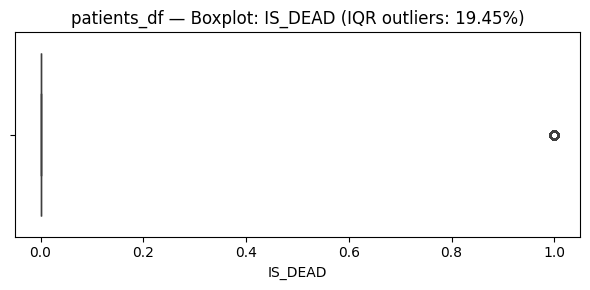

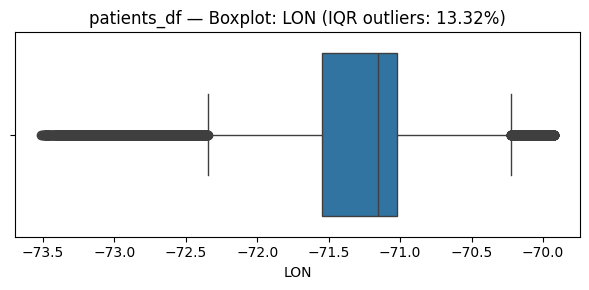

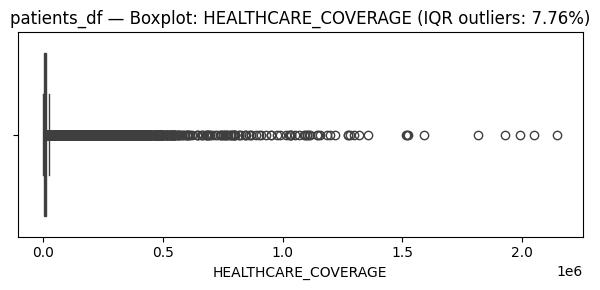


--- Outlier summary for observations_df ---
No numeric columns to analyze.

--- Outlier summary for careplans_df ---


,column,iqr_outliers,iqr_outlier_pct,z_outliers,z_outlier_pct
0,CODE,530,0.18,530,0.18
1,REASONCODE,14,0.00,14,0.00
2,IS_ONGOING,0,0.00,0,0.00



--- Outlier summary for encounters_df ---


,column,iqr_outliers,iqr_outlier_pct,z_outliers,z_outlier_pct
0,CODE,463667,23.47,44006,2.23
4,LENGTH_OF_STAY_DAYS,62217,3.15,1943,0.10
1,BASE_ENCOUNTER_COST,19631,0.99,19631,0.99
2,TOTAL_CLAIM_COST,19631,0.99,19631,0.99
3,PAYER_COVERAGE,0,0.00,0,0.00


Columns with >5% IQR outliers:


,column,iqr_outlier_pct,z_outlier_pct
0,CODE,23.47,2.23


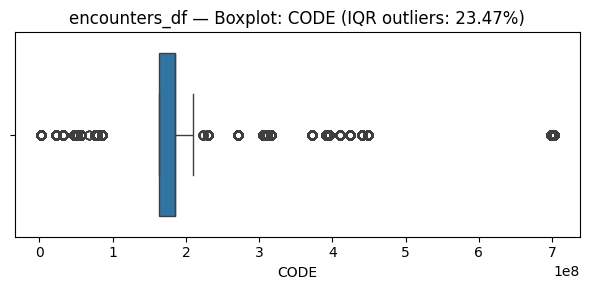


--- Outlier summary for devices_df ---


,column,iqr_outliers,iqr_outlier_pct,z_outliers,z_outlier_pct
1,IS_ONGOING,3555,19.16,0,0.0
0,CODE,0,0.00,0,0.0


Columns with >5% IQR outliers:


,column,iqr_outlier_pct,z_outlier_pct
1,IS_ONGOING,19.16,0.0


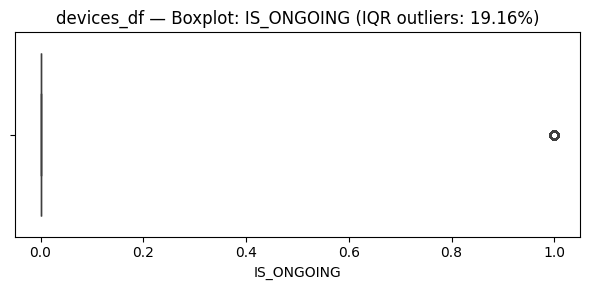


--- Outlier summary for supplies_df ---


,column,iqr_outliers,iqr_outlier_pct,z_outliers,z_outlier_pct
1,QUANTITY,24175,1.74,24175,1.74
0,CODE,0,0.00,8885,0.64



--- Outlier summary for procedures_df ---


,column,iqr_outliers,iqr_outlier_pct,z_outliers,z_outlier_pct
2,REASONCODE,262929,33.04,274,0.03
1,BASE_COST,186645,23.45,15777,1.98
0,CODE,9702,1.22,569,0.07


Columns with >5% IQR outliers:


,column,iqr_outlier_pct,z_outlier_pct
2,REASONCODE,33.04,0.03
1,BASE_COST,23.45,1.98


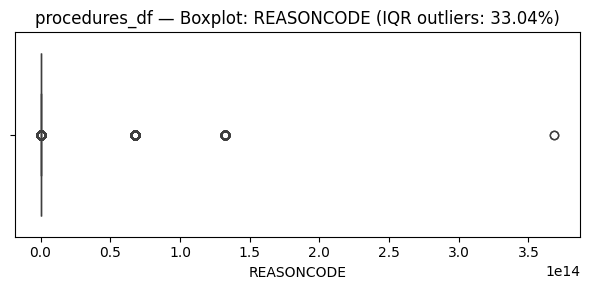

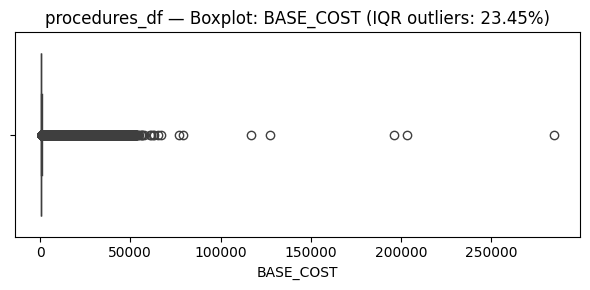


--- Outlier summary for medications_df ---


,column,iqr_outliers,iqr_outlier_pct,z_outliers,z_outlier_pct
5,REASONCODE,1057293,42.27,6208,0.25
0,CODE,202500,8.09,164,0.01
6,IS_ONGOING,189254,7.57,189254,7.57
1,BASE_COST,161131,6.44,19814,0.79
2,PAYER_COVERAGE,88993,3.56,36601,1.46
4,TOTALCOST,63849,2.55,17012,0.68
3,DISPENSES,50436,2.02,33729,1.35


Columns with >5% IQR outliers:


,column,iqr_outlier_pct,z_outlier_pct
5,REASONCODE,42.27,0.25
0,CODE,8.09,0.01
6,IS_ONGOING,7.57,7.57
1,BASE_COST,6.44,0.79


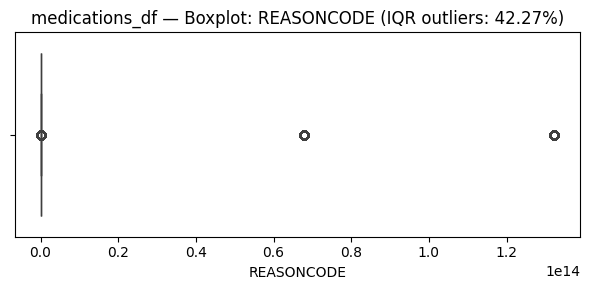

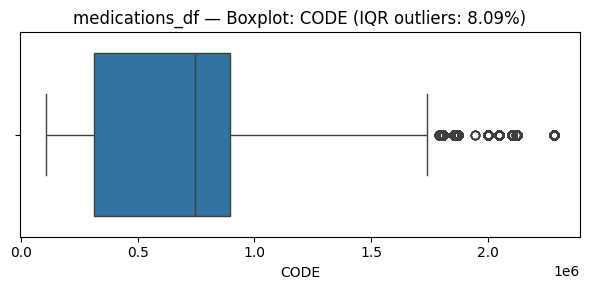

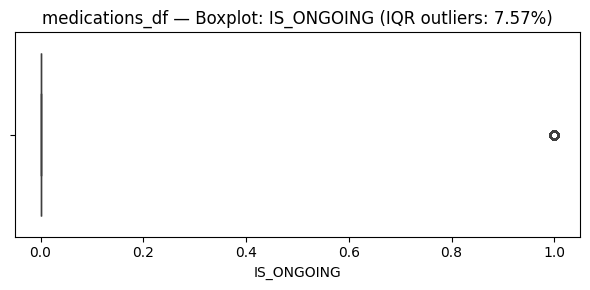

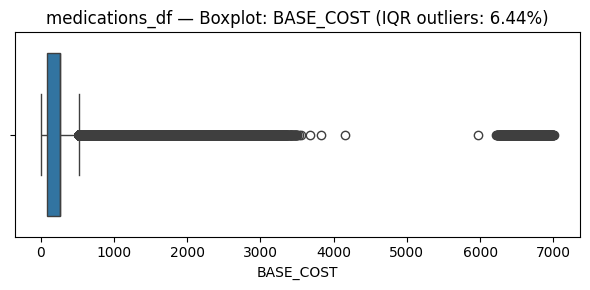

In [18]:
# ==============================================================================
# Cell 11: Outlier detection summary (IQR & Z-score) + Boxplots for flagged columns
# ==============================================================================
for name, df in dfs.items():
    if df.empty:
        continue
    print(f"\n--- Outlier summary for {name} ---")
    
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if not numeric_cols:
        print("No numeric columns to analyze.")
        continue

    outlier_data = []
    for col in numeric_cols:
        col_data = df[col].dropna()
        if col_data.empty:
            continue

        # IQR method
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)].count()
        iqr_outlier_pct = (iqr_outliers / len(col_data)) * 100 if len(col_data) > 0 else 0

        # Z-score method
        mean = col_data.mean()
        std = col_data.std(ddof=0)
        if std == 0:
            z_outliers = 0
            z_outlier_pct = 0
        else:
            z_scores = (col_data - mean).abs() / std
            z_outliers = (z_scores > 3).sum()
            z_outlier_pct = (z_outliers / len(col_data)) * 100 if len(col_data) > 0 else 0

        outlier_data.append({
            "column": col,
            "iqr_outliers": iqr_outliers,
            "iqr_outlier_pct": round(iqr_outlier_pct, 2),
            "z_outliers": z_outliers,
            "z_outlier_pct": round(z_outlier_pct, 2)
        })

    if not outlier_data:
        print("Not enough numeric data to compute outliers.")
        continue

    out_df = pd.DataFrame(outlier_data).sort_values(by="iqr_outlier_pct", ascending=False)
    display(out_df.head(20))

    flagged = out_df[out_df["iqr_outlier_pct"] > 5]
    if not flagged.empty:
        print("Columns with >5% IQR outliers:")
        display(flagged[["column", "iqr_outlier_pct", "z_outlier_pct"]])

        # Plot boxplots for flagged columns
        for col in flagged['column']:
            if col in df.columns:
                plt.figure(figsize=(6, 3))
                sns.boxplot(x=df[col].dropna())
                plt.title(f"{name} — Boxplot: {col} (IQR outliers: {flagged.loc[flagged['column'] == col, 'iqr_outlier_pct'].values[0]}%)")
                plt.tight_layout()
                plt.show()

In [19]:
# ==============================================================================
# Cell 12: Feature engineering and safe merges to create patient_features
# ==============================================================================
# Ensure required frames exist
required = ['conditions_df', 'encounters_df', 'patients_df', 'medications_df']
for r in required:
    if r not in dfs or dfs[r].empty:
        print(f"⚠️ Warning: {r} missing or empty. Skipping patient_features creation.")
        patient_features = pd.DataFrame()
        break
else:
    conditions_df = dfs['conditions_df']
    encounters_df = dfs['encounters_df']
    patients_df = dfs['patients_df']
    medications_df = dfs['medications_df']
    observations_df = dfs.get('observations_df', pd.DataFrame())

    # Convert START and STOP to datetime for conditions_df
    if 'START' in conditions_df.columns and 'STOP' in conditions_df.columns:
        conditions_df['START'] = pd.to_datetime(conditions_df['START'], errors='coerce')
        conditions_df['STOP'] = pd.to_datetime(conditions_df['STOP'], errors='coerce')
        conditions_df.loc[:, 'START_YEAR'] = conditions_df['START'].dt.year
        conditions_df.loc[:, 'START_MONTH'] = conditions_df['START'].dt.month
        conditions_df.loc[:, 'DURATION_DAYS'] = (conditions_df['STOP'] - conditions_df['START']).dt.days.fillna(0)

    encounters_per_patient = (
        encounters_df.groupby("PATIENT").size().reset_index(name="TOTAL_ENCOUNTERS")
        if 'PATIENT' in encounters_df.columns else pd.DataFrame()
    )
    cost_per_patient = (
        encounters_df.groupby("PATIENT")["BASE_ENCOUNTER_COST"].sum().reset_index(name="TOTAL_ENCOUNTER_COST")
        if 'PATIENT' in encounters_df.columns and 'BASE_ENCOUNTER_COST' in encounters_df.columns else pd.DataFrame()
    )
    med_cost_per_patient = (
        medications_df.groupby("PATIENT")["TOTALCOST"].sum().reset_index(name="TOTAL_MED_COST")
        if 'PATIENT' in medications_df.columns and 'TOTALCOST' in medications_df.columns else pd.DataFrame()
    )

    # Merge step-by-step with reports
    patient_features = patients_df.copy()
    print("Initial patient_features shape:", patient_features.shape)
    if not encounters_per_patient.empty:
        patient_features = patient_features.merge(encounters_per_patient, left_on="Id", right_on="PATIENT", how="left")
        print("Merged encounters_per_patient ->", patient_features.shape)
    if not cost_per_patient.empty:
        patient_features = patient_features.merge(cost_per_patient, left_on="Id", right_on="PATIENT", how="left")
        print("Merged cost_per_patient ->", patient_features.shape)
    if not med_cost_per_patient.empty:
        patient_features = patient_features.merge(med_cost_per_patient, left_on="Id", right_on="PATIENT", how="left")
        print("Merged med_cost_per_patient ->", patient_features.shape)

    # Cleanup
    patient_features.drop(columns=[c for c in ['PATIENT_x','PATIENT_y','PATIENT'] if c in patient_features.columns], inplace=True, errors='ignore')
    patient_features.fillna(0, inplace=True)

    # Convert BIRTHDATE to datetime before calculating AGE
    if 'BIRTHDATE' in patient_features.columns:
        patient_features['BIRTHDATE'] = pd.to_datetime(patient_features['BIRTHDATE'], errors='coerce')
        patient_features.loc[:, 'AGE'] = ((pd.Timestamp.now() - patient_features['BIRTHDATE']).dt.days // 365).astype(int)

    print("Final patient_features shape:", patient_features.shape)
    display(patient_features.head(3))

Initial patient_features shape: (124150, 23)
Merged encounters_per_patient -> (124150, 25)
Merged cost_per_patient -> (124150, 27)
Merged med_cost_per_patient -> (124150, 29)
Final patient_features shape: (124150, 27)


,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,MARITAL,...,COUNTY,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,IS_DEAD,TOTAL_ENCOUNTERS,TOTAL_ENCOUNTER_COST,TOTAL_MED_COST,AGE
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,2017-08-24,0,999-68-6630,S99916916,X11495287X,mr.,Jacinto644,Kris249,m,...,hampden county,42.151961,-72.598959,8446.49,1499.08,0,5.0,645.80,12.77,8
1,9bcf6ed5-d808-44af-98a0-7d78a29ede72,2016-08-01,0,999-15-5895,S99916916,X11495287X,mr.,Alva958,Krajcik437,m,...,norfolk county,42.177370,-71.281353,94568.40,1870.72,0,5.0,645.80,19.15,9
2,5163c501-353c-4a82-b863-a3f1df2d6cf1,2004-01-09,0,999-73-2461,S99999063,X11495287X,mr.,Jimmie93,Harris789,m,...,plymouth county,42.075292,-70.757035,375754.62,3131.44,0,6.0,774.96,153.97,21


In [ ]:
# # ==============================================================================
# # Enhanced EDA: type-aware visualizations
# # ==============================================================================

# for name, df in dfs.items():
#     if df.empty:
#         continue
#     print(f"\n📊 EDA for {name} — Shape: {df.shape}")
    
#     numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
#     cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

#     # ----------------------------------------------------------------------
#     # 1. Univariate Analysis
#     # ----------------------------------------------------------------------
#     # Numeric → Histograms & KDE
#     for col in numeric_cols:
#         plt.figure(figsize=(6, 4))
#         sns.histplot(df[col].dropna(), kde=True, bins=20)
#         plt.title(f"{name} — Distribution of {col}")
#         plt.tight_layout()
#         plt.show()

#     # Categorical → Bar plots
#     for col in cat_cols:
#         plt.figure(figsize=(6, 4))
#         df[col].value_counts().plot(kind="bar")
#         plt.title(f"{name} — Frequency of {col}")
#         plt.tight_layout()
#         plt.show()

#     # ----------------------------------------------------------------------
#     # 2. Bivariate Analysis
#     # ----------------------------------------------------------------------
#     # Num vs Num → Correlation + scatter plots
#     if len(numeric_cols) > 1:
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
#         plt.title(f"{name} — Correlation Heatmap")
#         plt.show()

#         # Scatter for first 2 numeric cols (example)
#         plt.figure(figsize=(6, 4))
#         sns.scatterplot(x=numeric_cols[0], y=numeric_cols[1], data=df)
#         plt.title(f"{name} — {numeric_cols[0]} vs {numeric_cols[1]}")
#         plt.tight_layout()
#         plt.show()

#     # Cat vs Num → Boxplots / Violin
#     for ccat in cat_cols:
#         if df[ccat].nunique() <= 10:  # limit to avoid clutter
#             for cnum in numeric_cols:
#                 plt.figure(figsize=(6, 4))
#                 sns.boxplot(x=ccat, y=cnum, data=df)
#                 plt.title(f"{name} — {cnum} by {ccat}")
#                 plt.tight_layout()
#                 plt.show()

#     # Cat vs Cat → Countplots
#     if len(cat_cols) >= 2:
#         plt.figure(figsize=(6, 4))
#         sns.countplot(x=cat_cols[0], hue=cat_cols[1], data=df)
#         plt.title(f"{name} — {cat_cols[0]} vs {cat_cols[1]}")
#         plt.tight_layout()
#         plt.show()

# # --- Specific patient_features extras ---
# if not patient_features.empty:
#     if {'AGE', 'GENDER'}.issubset(patient_features.columns):
#         plt.figure(figsize=(8, 4))
#         sns.violinplot(x='GENDER', y='AGE', data=patient_features)
#         plt.title("Age distribution by Gender (patient_features)")
#         plt.show()

#     if 'GENDER' in patient_features.columns:
#         plt.figure(figsize=(5, 3))
#         patient_features['GENDER'].value_counts().plot(kind='pie', autopct='%1.1f%%')
#         plt.title("Gender Proportions (patient_features)")
#         plt.ylabel("")
#         plt.show()


In [20]:
# ==============================================================================
# Diagnostic Accuracy & Outcomes
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dfs' and 'patient_features' are already available from previous cells.

# ------------------------------------------------------------------------------
# Analysis of Mortality
# ------------------------------------------------------------------------------
print("\n===== Analyzing Mortality and Related Factors =====")
if not patient_features.empty and 'IS_DEAD' in patient_features.columns:
    print(patient_features['IS_DEAD'].value_counts(normalize=True))
    
    dead_patients = patient_features[patient_features['IS_DEAD'] == 1]
    alive_patients = patient_features[patient_features['IS_DEAD'] == 0]
    
    # Compare costs for dead vs. alive patients
    if not dead_patients.empty and not alive_patients.empty and 'TOTAL_ENCOUNTER_COST' in patient_features.columns:
        print("\nAverage total encounter cost (all patients):")
        print(f"  - Deceased: ${dead_patients['TOTAL_ENCOUNTER_COST'].mean():.2f}")
        print(f"  - Alive: ${alive_patients['TOTAL_ENCOUNTER_COST'].mean():.2f}")

    # Identify most common conditions for deceased patients
    if not dfs['conditions_df'].empty:
        dead_patient_ids = dead_patients['Id']
        dead_conditions = dfs['conditions_df'][dfs['conditions_df']['PATIENT'].isin(dead_patient_ids)]
        top_conditions = dead_conditions['DESCRIPTION'].value_counts().head(5)
        print("\nTop 5 conditions among deceased patients:")
        print(top_conditions)
else:
    print("⚠️ Missing 'IS_DEAD' column in patient_features for mortality analysis.")

# ------------------------------------------------------------------------------
# Analyzing Re-admissions
# ------------------------------------------------------------------------------
print("\n===== Analyzing Re-admissions =====")
encounters_df = dfs.get('encounters_df')
if not encounters_df.empty and 'START' in encounters_df.columns:
    encounters_df.loc[:, 'START'] = pd.to_datetime(encounters_df['START'])
    encounters_df = encounters_df.sort_values(by=['PATIENT', 'START']).reset_index(drop=True)
    
    # Calculate time difference between consecutive encounters for each patient
    encounters_df.loc[:, 'PREV_ENCOUNTER_START'] = encounters_df.groupby('PATIENT')['START'].shift(1)
    encounters_df.loc[:, 'TIME_TO_NEXT_ENCOUNTER'] = (encounters_df['START'] - encounters_df['PREV_ENCOUNTER_START']).dt.days

    # Define re-admission as a new encounter within 30 days
    readmission_threshold = 30
    encounters_df.loc[:, 'IS_READMISSION'] = encounters_df['TIME_TO_NEXT_ENCOUNTER'].apply(lambda x: 1 if 0 < x <= readmission_threshold else 0)

    total_readmissions = encounters_df['IS_READMISSION'].sum()
    total_encounters = len(encounters_df)
    readmission_rate = (total_readmissions / total_encounters) * 100
    
    print(f"Total encounters analyzed: {total_encounters}")
    print(f"Total re-admissions (within {readmission_threshold} days): {total_readmissions}")
    print(f"Overall re-admission rate: {readmission_rate:.2f}%")

    # Link re-admissions to previous care
    readmission_encounters = encounters_df[encounters_df['IS_READMISSION'] == 1]
    
    if not readmission_encounters.empty:
        # Get the previous encounter ID and link it back to careplans and procedures
        readmission_encounters.loc[:, 'PREV_ENCOUNTER_ID'] = encounters_df.loc[readmission_encounters.index - 1, 'Id'].values
        
        # Merge with careplans and procedures to see what preceded re-admission
        careplans_df = dfs.get('careplans_df')
        procedures_df = dfs.get('procedures_df')

        if not careplans_df.empty and not procedures_df.empty:
            readmission_careplans = readmission_encounters.merge(careplans_df, left_on='PREV_ENCOUNTER_ID', right_on='ENCOUNTER', how='left', suffixes=('_readmit', '_prev'))
            readmission_procedures = readmission_encounters.merge(procedures_df, left_on='PREV_ENCOUNTER_ID', right_on='ENCOUNTER', how='left', suffixes=('_readmit', '_prev'))
            
            # Analyze patterns
            if not readmission_careplans.empty:
                print("\nTop 5 care plan descriptions preceding re-admissions:")
                print(readmission_careplans['DESCRIPTION_prev'].value_counts().head(5))

            if not readmission_procedures.empty:
                print("\nTop 5 procedures preceding re-admissions:")
                print(readmission_procedures['DESCRIPTION_prev'].value_counts().head(5))
    else:
        print("No re-admissions found based on the 30-day threshold.")
else:
    print("⚠️ Encounters data not available for re-admission analysis.")


===== Analyzing Mortality and Related Factors =====
0    0.805477
1    0.194523
Name: IS_DEAD, dtype: float64

Average total encounter cost (all patients):
  - Deceased: $1239.93
  - Alive: $2241.83

Top 5 conditions among deceased patients:
suspected covid-19              3641
covid-19                        3641
respiratory distress finding    3546
hypoxemia disorder              3546
pneumonia disorder              3546
Name: DESCRIPTION, dtype: int64

===== Analyzing Re-admissions =====


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\176001260.py:43: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  encounters_df.loc[:, 'START'] = pd.to_datetime(encounters_df['START'])


Total encounters analyzed: 1975394
Total re-admissions (within 30 days): 363453
Overall re-admission rate: 18.40%


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\176001260.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readmission_encounters.loc[:, 'PREV_ENCOUNTER_ID'] = encounters_df.loc[readmission_encounters.index - 1, 'Id'].values



Top 5 care plan descriptions preceding re-admissions:
infectious disease care plan record artifact    27824
self-care interventions procedure                9288
lifestyle education regarding hypertension       6322
respiratory therapy                              4793
routine antenatal care                           2664
Name: DESCRIPTION_prev, dtype: int64

Top 5 procedures preceding re-admissions:
oxygen administration by mask procedure                                              70997
placing subject in prone position procedure                                          67079
evaluation of uterine fundal height                                                  20360
auscultation of the fetal heart                                                      20360
controlled ventilation procedure and therapy  initiation and management procedure    20150
Name: DESCRIPTION_prev, dtype: int64


In [23]:
# ==============================================================================
# Resource Utilization - Average Length of Stay
# ==============================================================================
print("\n===== Average Length of Stay for Major Conditions =====")
encounters_df = dfs.get('encounters_df')
conditions_df = dfs.get('conditions_df')

if not encounters_df.empty and not conditions_df.empty:
    # Ensure date columns are in datetime format
    encounters_df.loc[:, 'START'] = pd.to_datetime(encounters_df['START'])
    encounters_df.loc[:, 'STOP'] = pd.to_datetime(encounters_df['STOP'])
    
    # Calculate length of stay (in days)
    encounters_df.loc[:, 'LENGTH_OF_STAY_DAYS'] = (encounters_df['STOP'] - encounters_df['START']).dt.days

    # Merge encounters with conditions to link length of stay to a condition
    # FIXED: Merging on encounters_df['Id'] and conditions_df['ENCOUNTER']
    # FIXED: Added suffixes to handle the duplicate 'DESCRIPTION' column name.
    merged_df = encounters_df.merge(conditions_df, left_on='Id', right_on='ENCOUNTER', how='inner', suffixes=('_enc', '_cond'))
    
    # Calculate average length of stay for each condition and sort
    # FIXED: The column to group by is 'DESCRIPTION_cond', which was created by the merge.
    avg_los_by_condition = merged_df.groupby('DESCRIPTION_cond')['LENGTH_OF_STAY_DAYS'].mean().sort_values(ascending=False)
    
    # Get the most frequent conditions to show meaningful results
    top_conditions_counts = conditions_df['DESCRIPTION'].value_counts().head(10).index
    avg_los_by_top_conditions = avg_los_by_condition.reindex(top_conditions_counts).dropna()

    print("Top 10 most common conditions and their average length of stay:")
    print(avg_los_by_top_conditions)
else:
    print("⚠️ Encounters or Conditions data not available for length of stay analysis.")


===== Average Length of Stay for Major Conditions =====


C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3004869203.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  encounters_df.loc[:, 'START'] = pd.to_datetime(encounters_df['START'])
C:\Users\HP\AppData\Local\Temp\ipykernel_16780\3004869203.py:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  encounters_df.loc[:, 'STOP'] = pd.to_datetime(encounters_df['STOP'])


Top 10 most common conditions and their average length of stay:
suspected covid-19                        0.000374
covid-19                                  0.000136
fever finding                             0.000421
cough finding                             0.000552
loss of taste finding                     0.000739
body mass index 30+ - obesity finding    13.584668
fatigue finding                           0.000975
sputum finding finding                    0.000000
prediabetes                               0.001808
hypertension                              0.001564
Name: LENGTH_OF_STAY_DAYS, dtype: float64


In [15]:
# ==============================================================================
# Resource Utilization - Common Procedures and Supplies
# ==============================================================================
print("\n===== Common Procedures and Supplies in Hospital Stays =====")
encounters_df = dfs.get('encounters_df')
procedures_df = dfs.get('procedures_df')
supplies_df = dfs.get('supplies_df')

if not encounters_df.empty and not procedures_df.empty and not supplies_df.empty:
    # Identify hospital stays (inpatient encounters)
    if 'ENCOUNTERCLASS' in encounters_df.columns:
        inpatient_encounters = encounters_df[encounters_df['ENCOUNTERCLASS'] == 'inpatient']['Id'].unique()
    else:
        print("⚠️ 'ENCOUNTERCLASS' column not found in encounters_df. Skipping analysis.")
        inpatient_encounters = []
    
    if len(inpatient_encounters) > 0:
        # Filter procedures and supplies for inpatient encounters
        inpatient_procedures = procedures_df[procedures_df['ENCOUNTER'].isin(inpatient_encounters)]
        inpatient_supplies = supplies_df[supplies_df['ENCOUNTER'].isin(inpatient_encounters)]

        # Get the top 5 most common procedures
        if not inpatient_procedures.empty:
            top_procedures = inpatient_procedures['DESCRIPTION'].value_counts().head(5)
            print("\nTop 5 most common procedures during inpatient stays:")
            print(top_procedures)
        else:
            print("\nNo procedures found for inpatient stays.")

        # Get the top 5 most common supplies
        if not inpatient_supplies.empty:
            # For supplies, we can aggregate the quantity
            top_supplies = inpatient_supplies.groupby('DESCRIPTION')['QUANTITY'].sum().sort_values(ascending=False).head(5)
            print("\nTop 5 most common supplies (by quantity) during inpatient stays:")
            print(top_supplies)
        else:
            print("\nNo supplies found for inpatient stays.")
    else:
        print("No inpatient encounters found.")
else:
    print("⚠️ Required dataframes (encounters, procedures, or supplies) not available.")


===== Common Procedures and Supplies in Hospital Stays =====

Top 5 most common procedures during inpatient stays:
oxygen administration by mask procedure                                              191447
placing subject in prone position procedure                                          187021
plain chest x-ray procedure                                                           21089
controlled ventilation procedure and therapy  initiation and management procedure     19883
hemodialysis procedure                                                                 8942
Name: DESCRIPTION, dtype: int64

Top 5 most common supplies (by quantity) during inpatient stays:
DESCRIPTION
nitrile examination/treatment glove  non-powdered  sterile physical object    5552856
isolation gown  single-use physical object                                    2486680
antiseptic towelette physical object                                          1877642
disposable air-purifying respirator physical object     